In [ ]:
# creative prompts

creative_prompts = ["Write a poem", "Tell me a joke", "Describe the feeling of love", "Write a story starting with 'Once upon a time...'",
                    "Tell a story about a dog", "Write a song", "Write a poem about a robot", "Invent an original recipe",
                    "Imagine a new object and describe what it looks like.", "Imagine a new philosophy and describe it.", 
                    "Create a new game and explain the rules.", "Write a new myth explaining the origin of rainbows.", 
                    "Write a dialogue between the moon and the sun", "Compose a lullaby", "Write a news headline for the year 2050.",
                    "Invent a riddle and write it down.", "Write a story about two people seeing each other for the first time.",
                    "Write a story about a person who is afraid of the dark.", "Make a new pun about llamas.", "Invent a new word and define it."]

# factual prompts
factual_prompts = ["What is the capital of France?", "How is H2O commonly known?", "What is the largest country in the world?", "How many days are in a year?",
                   "What is the largest planet in the solar system?", "What is the largest animal in the world?", "How do you say hello in Spanish?", "Who won the 2018 World Cup?",
                   "What is the biggest city in Europe?", "What is the largest country in Africa?", "What was the last battle of Napoleon?", "How do you call someone from New Zealand?",
                   "How do you call someone who studies plants?", "Who invented the telephone?", "What mammal lays eggs?", "Which bone is the longest in the human body?", "What is the anthem of France?",
                   "Who wrote Cannery Row?", "Who was the first president of the United States?", "Which painter painted the Mona Lisa?"]



# factual prompts whose answers are longer
# not used right now
factual_prompts_longer = ["What separates prehistory from history?", "How were hyerogliphics deciphered?"]

print(len(creative_prompts))
print(len(factual_prompts))








# Generate completions

In [ ]:
def format_prompt_llama2(prompt):
    prompt_format = """<s>[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer without asking questions or clarifications.
    <</SYS>>

    {} [/INST]"""
    return prompt_format.format(prompt)

def format_prompt_vicuna(prompt, version="1.5"):
    model_path = "lmsys/vicuna-7b-v" + version
    conv = get_conversation_template(model_path)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    full_prompt = conv.get_prompt()
    return full_prompt

#prompt = prompt_format.format("What is the best way to get to the airport?")
#input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
#output_ids = model.generate(input_ids, max_length=300, pad_token_id=tokenizer.eos_token_id, do_sample=True, temperature=1.2, num_return_sequences=2)

#print(tokenizer.decode(output_ids[0], skip_special_tokens=True))


In [10]:
temperatures = [k / 10. for k in range(1, 16)]

In [ ]:
import submitit
import os
from fastchat.model import get_conversation_template
import numpy as np
#imports
from transformers import AutoTokenizer, AutoModelForCausalLM

# each temperature and for each prompt, generate n_generations samples
temperatures = [k / 10. for k in range(1, 16)]
models = ["llama2-chat", "vicuna1.5"]
n_generations = 25
completions_creative = np.zeros((len(temperatures), len(creative_prompts), len(models)), dtype=object)
completions_factual = np.zeros((len(temperatures), len(factual_prompts), len(models)), dtype=object)

# define the function to be submitted
def generate_samples(args):
    max_return_sequences = 5 #for memory reasons, we generate the samples in batches of 5
    i, prompt, temperatures, model_name = args
    if model_name == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model_name == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    completions = []
    for temperature in temperatures:
        temp_completions = []
        for _ in range(n_generations // max_return_sequences):
            samples = model.generate(input_ids, temperature=temperature, max_length=input_ids.shape[1] + 70,
                                    num_return_sequences=max_return_sequences, do_sample=True)
            # remove prompt from the samples
            samples = [sample[input_ids.shape[1]:] for sample in samples]
            samples = [tokenizer.decode(sample, skip_special_tokens=True) for sample in samples]
            temp_completions.extend(samples)
        completions.append(temp_completions)
    return completions

# create a folder for the logs of the submitted jobs
os.makedirs("logs", exist_ok=True)


for model in models:
    # create a submitit executor
    executor = submitit.AutoExecutor(folder="logs")

    # specify the parameters for the Slurm job
    #exclude margpu002 and margpu003
    executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                                # exclude nodes
                                exclude="margpu002,margpu003")
    
    # For creative prompts
    args_list_creative = [(i, prompt, temperatures, model) for i, prompt in enumerate(creative_prompts)]
    jobs_creative = executor.map_array(generate_samples, args_list_creative)

    # For factual prompts
    args_list_factual = [(i, prompt, temperatures, model) for i, prompt in enumerate(factual_prompts)]
    jobs_factual = executor.map_array(generate_samples, args_list_factual)

    # Collect the results for creative prompts
    for i, job in enumerate(jobs_creative):
        model_completions = job.result()
        for t_index, completion in enumerate(model_completions):
            completions_creative[t_index, i, models.index(model)] = completion

    # Collect the results for factual prompts
    for i, job in enumerate(jobs_factual):
        model_completions = job.result()
        for t_index, completion in enumerate(model_completions):
            completions_factual[t_index, i, models.index(model)] = completion

# Save the results
np.save("completions_creative_max_length70.npy", completions_creative)
np.save("completions_factual_max_length70.npy", completions_factual)


# Diversity metrics

In [3]:
from functools import partial
import torch
from torch.nn import CosineSimilarity
import numpy as np

# import metrics from https://github.com/CarperAI/diversity_metrics/tree/main

from sentence_transformers import SentenceTransformer
from diversity_metrics.metrics.model_free_metrics import *
from diversity_metrics.embeddings.models import *
from diversity_metrics.metrics.generalized_diversity import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def limit_num_words(sentence, max_num_words):
    return " ".join(sentence.split()[:max_num_words])

In [5]:
# import combinations
from itertools import combinations
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def average_pairwise_jaccard(sentences, n=2):
    return np.mean([pairwise_ngram(n, x, y) for x, y in combinations(sentences, 2)])

def self_bleu_smooth(sentences):
    '''
    Calculates the Self-BLEU score for a collection of generated examples (https://arxiv.org/abs/1802.01886)
    :param sentences: List of generated examples
    :return:
    '''

    scores = []
    for i, hypothesis in enumerate(sentences):
        hypothesis_split = hypothesis.strip().split()

        references = [sentences[j].strip().split() for j in range(len(sentences)) if i != j]

        scores.append(sentence_bleu(references, hypothesis_split, smoothing_function=SmoothingFunction().method1))

    return sum(scores) / len(scores)

In [6]:
diversity_metrics = {"selfBleuSmoothed": self_bleu_smooth,
                    "average_pairwise_ncd": lambda sentences: np.mean(get_pairwise_ncd(sentences)),
                     "average_pairwise_jaccard_2": partial(average_pairwise_jaccard, n=2),
                    "average_pairwise_jaccard_3": partial(average_pairwise_jaccard, n=3),
                    "average_pairwise_jaccard_4": partial(average_pairwise_jaccard, n=4),
                    "avg_compression_ratio_full": avg_compression_ratio_full,
                    "avg_compression_ratio_target": avg_compression_ratio_target,
                    "cosine_similarity": None # will be filled in later
                    }

pairwise_similarities = {"jaccard_2": partial(pairwise_ngram, 2), "cosine": None}
qs = [2,3,4,5,6]
num_samples = 50
def generate_metric_order(q, metric):
    return lambda sentences: diversity_order_q(sentences, q, metric, num_samples) # careful about lambda in loops
for q in qs:
    for key, metric in pairwise_similarities.items():
        diversity_metrics[f"order_{q}_{key}"] = generate_metric_order(q, metric)

from vendi_score import vendi

def generate_metric_vendi(metric):
    return lambda sentences: vendi.score(sentences, metric)
for key, metric in pairwise_similarities.items():
    diversity_metrics[f"vendi_{key}"] = generate_metric_vendi(metric)


In [7]:
def compute_metric(key, data, prompt_type):
    if "cosine" in key:
        sent_embedder = SBERTEmbedder()
        sent_embedder.model = sent_embedder.model.to(device)
        metric_func = partial(get_pairwise_cosine_sim, sent_embedder)
        if key == "cosine_similarity":
            metric = partial(get_avg_cosine_sim, sent_embedder)
        elif key.startswith("order_") and "cosine" in key:
            q = int(key.split("_")[1])
            metric_func = partial(get_pairwise_cosine_sim, sent_embedder)
            metric = lambda sentences: diversity_order_q(sentences, q, metric_func, num_samples)
        elif key.startswith("vendi_") and "cosine" in key:
            metric_func = partial(get_pairwise_cosine_sim, sent_embedder)
            metric = lambda sentences: vendi.score(sentences, metric_func)
    else:
        metric = diversity_metrics[key]

    result = np.zeros_like(data, dtype=np.float32)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                try:
                    result[i, j, k] = metric(data[i, j, k])
                except:
                    result[i, j, k] = np.nan
                print(result[i, j, k])
    return key, result, prompt_type


In [ ]:
completions_creative = np.load("completions_creative_max_length70.npy", allow_pickle=True)
completions_factual = np.load("completions_factual_max_length70.npy", allow_pickle=True)

In [ ]:
import submitit
import numpy as np
from functools import partial

# Define the tasks that require a GPU
gpu_required_tasks = {key for key in diversity_metrics.keys() if "cosine" in key}

# Define your submitit executor with base parameters
executor = submitit.AutoExecutor(folder="submitit_jobs/")
executor.update_parameters(
    timeout_min=60,  # Set to the max runtime of your job
    slurm_partition="parietal,normal,gpu",  # Specify a default partition
)

max_num_words = 20

# Split work and submit to executor
jobs = []
for key, metric in diversity_metrics.items():
    for data_full in [completions_creative, completions_factual]:
        # truncate the sentences to max_num_words
        data = np.zeros_like(data_full, dtype=object)
        for i in range(data_full.shape[0]):
            for j in range(data_full.shape[1]):
                for k in range(data_full.shape[2]):
                    data[i, j, k] = list(map(lambda sentence: limit_num_words(sentence, max_num_words), data_full[i, j, k]))
        if key in gpu_required_tasks:
            executor.update_parameters(gpus_per_node=1)  # Update GPU setting only for this specific job
        else:
            executor.update_parameters(gpus_per_node=0)#, exclude=",".join(f"margpu{k:03d}" for k in range(2, 11)))
        
        job = executor.submit(compute_metric, key, data, "creative" if data_full is completions_creative else "factual")
        jobs.append(job)

# Gather results
results = {"creative": {}, "factual": {}}
for job in jobs:
    metric_name, result_data, data_type = job.result()
    results[data_type][metric_name] = result_data

#np.save("results_20_words.npy", results)
#np.save("results_5_words.npy", results)


In [8]:
results_20_words = np.load("results_20_words.npy", allow_pickle=True).item()
results_5_words = np.load("results_5_words.npy", allow_pickle=True).item()

## Plot diversity metrics

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


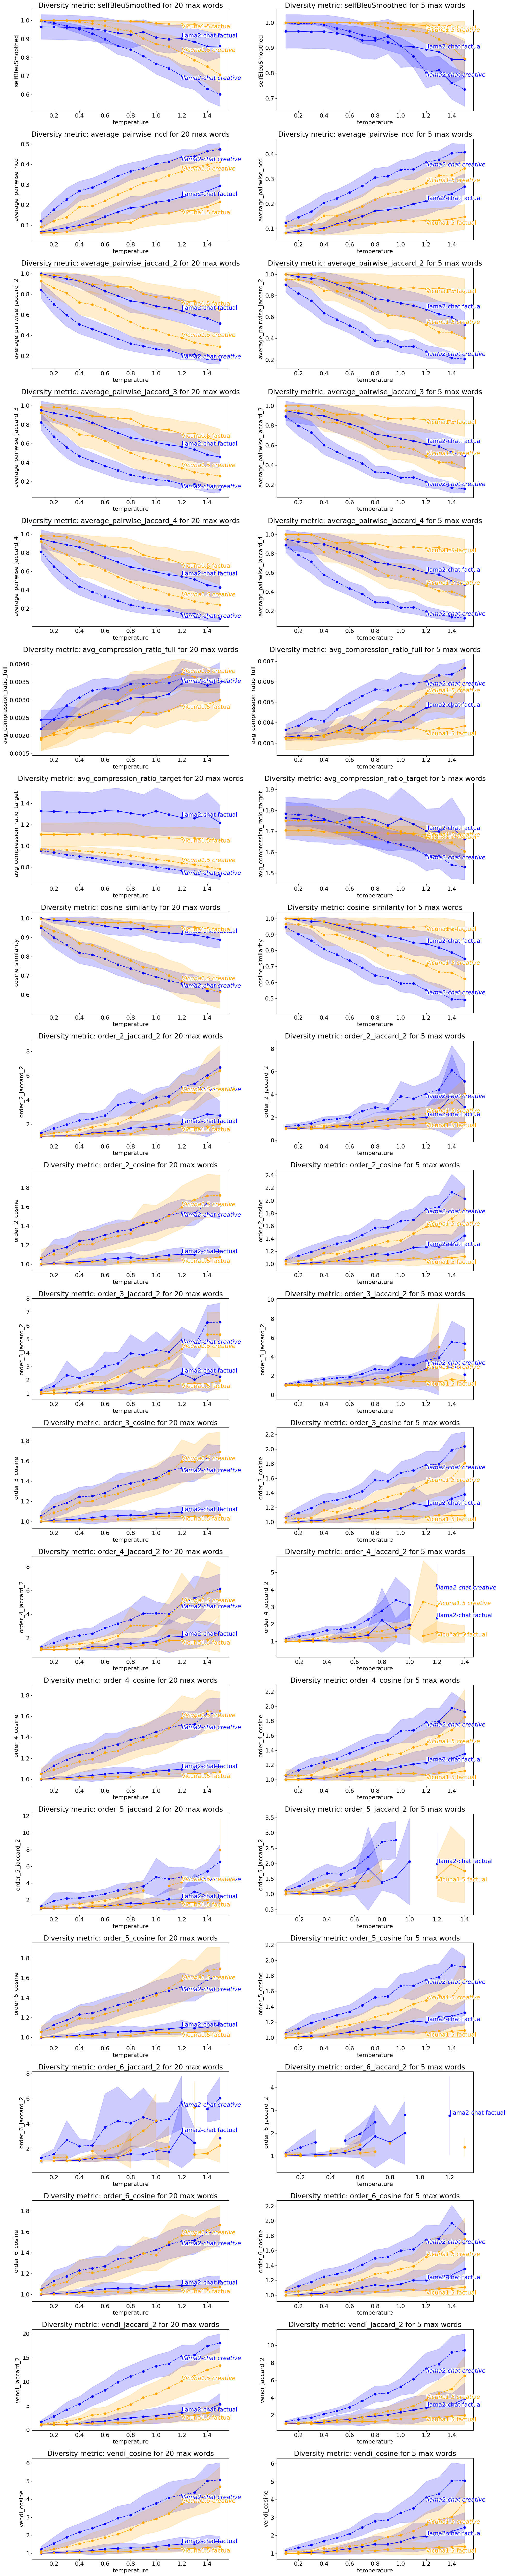

In [11]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np



num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result in enumerate([results_20_words, results_5_words]):
        ax = axes[index, col_idx]

        scores_factual = result["factual"][metric]
        scores_creative = result["creative"][metric]

        # Plotting for factual scores
        ax.plot(temperatures, scores_factual[:, :, 0].mean(axis=1), label='llama2-chat', marker='o', color="blue")
        ax.fill_between(temperatures, scores_factual[:, :, 0].mean(axis=1) - 2 * scores_factual[:, :, 0].std(axis=1) / np.sqrt(scores_factual.shape[1]), 
                        scores_factual[:, :, 0].mean(axis=1) + 2 * scores_factual[:, :, 0].std(axis=1) / np.sqrt(scores_factual.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, scores_factual[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o', color="orange")
        ax.fill_between(temperatures, scores_factual[:, :, 1].mean(axis=1) - 2 * scores_factual[:, :, 1].std(axis=1) / np.sqrt(scores_factual.shape[1]), 
                        scores_factual[:, :, 1].mean(axis=1) + 2 * scores_factual[:, :, 1].std(axis=1) / np.sqrt(scores_factual.shape[1]), alpha=0.2, color="orange")

        # Plotting for creative scores
        ax.plot(temperatures, scores_creative[:, :, 0].mean(axis=1), label='llama2-chat creative', marker='o', linestyle='--', color="blue")
        ax.fill_between(temperatures, scores_creative[:, :, 0].mean(axis=1) - 2 * scores_creative[:, :, 0].std(axis=1) / np.sqrt(scores_creative.shape[1]), 
                        scores_creative[:, :, 0].mean(axis=1) + 2 * scores_creative[:, :, 0].std(axis=1) / np.sqrt(scores_creative.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, scores_creative[:, :, 1].mean(axis=1), label='Vicuna1.5 creative', marker='o', linestyle='--', color="orange")
        ax.fill_between(temperatures, scores_creative[:, :, 1].mean(axis=1) - 2 * scores_creative[:, :, 1].std(axis=1) / np.sqrt(scores_creative.shape[1]), 
                        scores_creative[:, :, 1].mean(axis=1) + 2 * scores_creative[:, :, 1].std(axis=1) / np.sqrt(scores_creative.shape[1]), alpha=0.2, color="orange")

        ax.set_xlabel('temperature')
        ax.set_ylabel(metric)
        ax.set_title(f'Diversity metric: {metric} for {20 if col_idx == 0 else 5} max words')
        #ax.legend()
        text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

        # Add labels directly on the plot with white outline
        end_temp = temperatures[-4]
        text_factual1 = ax.text(end_temp, scores_factual[:, :, 0].mean(axis=1)[-4], 'llama2-chat factual', color='blue', verticalalignment='bottom')
        text_factual1.set_path_effects(text_effect)

        text_factual2 = ax.text(end_temp, scores_factual[:, :, 1].mean(axis=1)[-4], 'Vicuna1.5 factual', color='orange', verticalalignment='top')
        text_factual2.set_path_effects(text_effect)

        text_creative1 = ax.text(end_temp, scores_creative[:, :, 0].mean(axis=1)[-4], 'llama2-chat creative', color='blue', verticalalignment='top', style='italic')
        text_creative1.set_path_effects(text_effect)

        text_creative2 = ax.text(end_temp, scores_creative[:, :, 1].mean(axis=1)[-4], 'Vicuna1.5 creative', color='orange', verticalalignment='bottom', style='italic')
        text_creative2.set_path_effects(text_effect)

plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


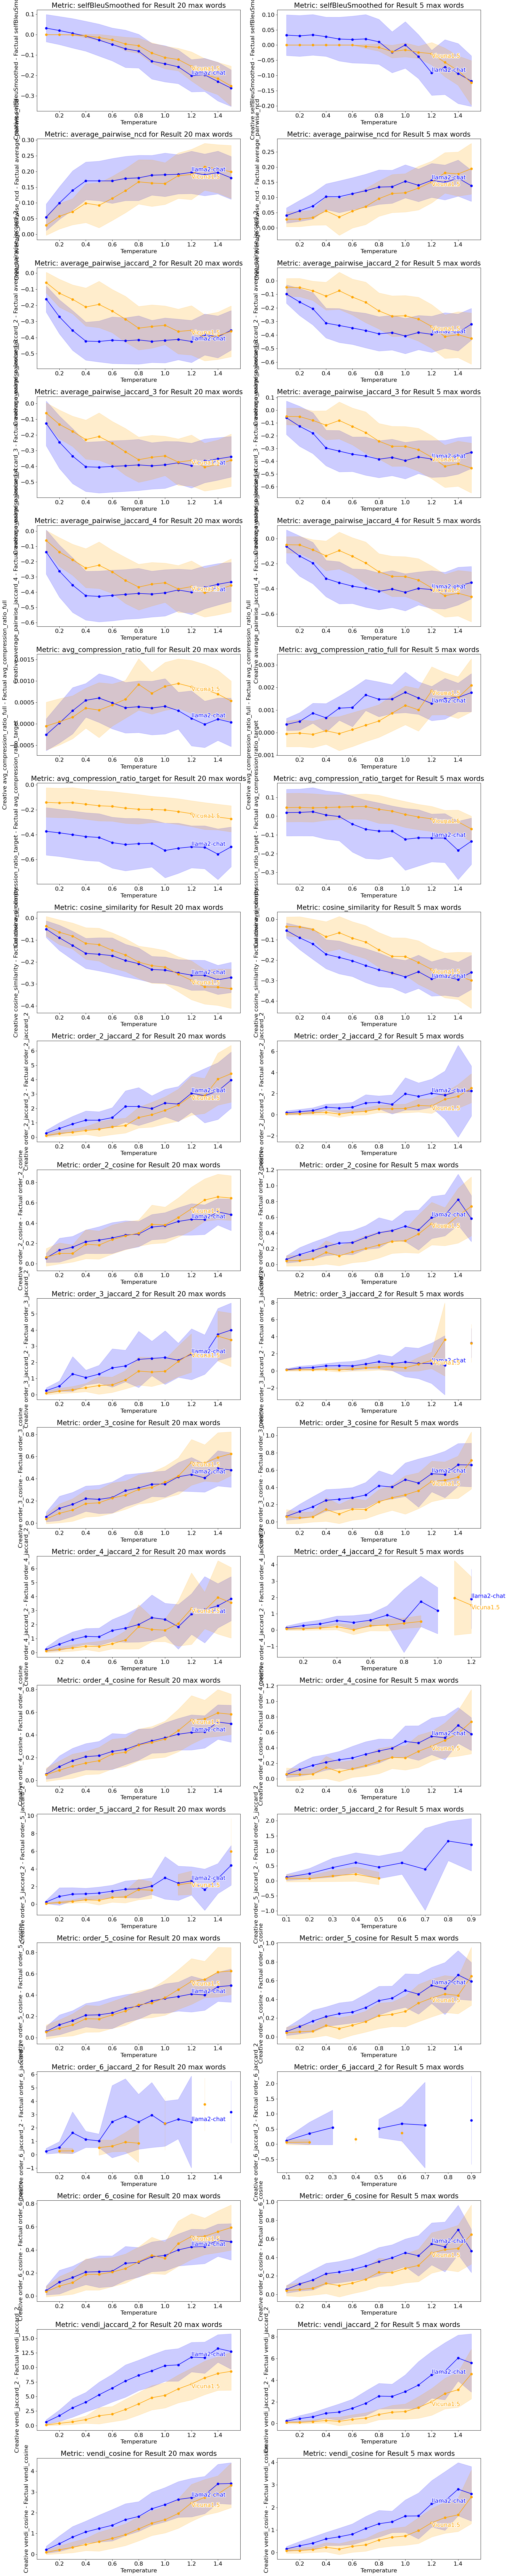

In [12]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np

num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})
text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result in enumerate([results_20_words, results_5_words]):
        ax = axes[index, col_idx]

        scores_factual = result["factual"][metric]
        scores_creative = result["creative"][metric]

        # Calculate differences
        diff_llamaa = scores_creative[:, :, 0] - scores_factual[:, :, 0]
        diff_vicuna = scores_creative[:, :, 1] - scores_factual[:, :, 1]

        # Plotting differences
        ax.plot(temperatures, diff_llamaa.mean(axis=1), label='llama2-chat', marker='o', color="blue")
        ax.fill_between(temperatures, diff_llamaa.mean(axis=1) - 2 * diff_llamaa.std(axis=1) / np.sqrt(diff_llamaa.shape[1]), 
                        diff_llamaa.mean(axis=1) + 2 * diff_llamaa.std(axis=1) / np.sqrt(diff_llamaa.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, diff_vicuna.mean(axis=1), label='Vicuna1.5', marker='o', color="orange")
        ax.fill_between(temperatures, diff_vicuna.mean(axis=1) - 2 * diff_vicuna.std(axis=1) / np.sqrt(diff_vicuna.shape[1]), 
                        diff_vicuna.mean(axis=1) + 2 * diff_vicuna.std(axis=1) / np.sqrt(diff_vicuna.shape[1]), alpha=0.2, color="orange")

        end_temp = temperatures[-4]
        text_llama = ax.text(end_temp, diff_llamaa.mean(axis=1)[-4], 'llama2-chat', color='blue', verticalalignment='bottom')
        text_llama.set_path_effects(text_effect)

        text_vicuna = ax.text(end_temp, diff_vicuna.mean(axis=1)[-4], 'Vicuna1.5', color='orange', verticalalignment='top')
        text_vicuna.set_path_effects(text_effect)

        ax.set_title(f"Metric: {metric} for Result {20 if col_idx == 0 else 5} max words")
        ax.set_xlabel("Temperature")
        ax.set_ylabel(f"Creative {metric} - Factual {metric}")

plt.tight_layout()
plt.show()


# Older stuff

In [ ]:
# Use submitit to run this script on a cluster

import submitit
import os
from fastchat.model import get_conversation_template

import numpy as np

# each temperature and for each prompt, generate n_generations samples
temperatures = [k / 10. for k in range(1, 16)]
print(temperatures)
models = ["llama2-chat", "vicuna1.5"]
n_generations = 25
bleu_scores_creative = np.zeros((len(temperatures), len(creative_prompts), len(models)))
bleu_scores_factual = np.zeros((len(temperatures), len(factual_prompts), len(models)))


# define the function to be submitted
def generate_samples(args):
    max_return_sequences = 5 #for memory reasons, we generate the samples in batches of 5
    i, prompt, temperatures, model_name = args
    if model_name == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model_name == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    bleu_scores = []
    for temperature in temperatures:
        samples = []
        for _ in range(n_generations // max_return_sequences):
            samples.extend(model.generate(input_ids, temperature=temperature, max_length=input_ids.shape[1] + 50,
                                            num_return_sequences=max_return_sequences, do_sample=True))
        # remove prompt from the samples
        samples = [sample[input_ids.shape[1]:] for sample in samples]
        samples = [tokenizer.decode(sample, skip_special_tokens=True) for sample in samples]
        print(f"Model: {model_name}")
        print(f"Prompt: {prompt}")
        print(f"Temperature: {temperature}")
        print(f"Samples: {samples}")
        bleu_score = self_BLEU(samples, split_sentences=True)
        print(f"BLEU score: {bleu_score}")
        bleu_scores.append(bleu_score)
    return bleu_scores

# create a folder for the logs of the submitted jobs
os.makedirs("logs", exist_ok=True)


for model in models:
    # create a submitit executor
    executor = submitit.AutoExecutor(folder="logs")

    # specify the parameters for the Slurm job
    #exclude margpu002 and margpu003
    executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                                # exclude nodes
                                exclude="margpu002,margpu003")
    
    # For creative prompts
    args_list_creative = [(i, prompt, temperatures, model) for i, prompt in enumerate(creative_prompts)]
    jobs_creative = executor.map_array(generate_samples, args_list_creative)

    # For factual prompts
    args_list_factual = [(i, prompt, temperatures, model) for i, prompt in enumerate(factual_prompts)]
    jobs_factual = executor.map_array(generate_samples, args_list_factual)

    # Collect the results for creative prompts
    for i, job in enumerate(jobs_creative):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_creative[t_index, i, models.index(model)] = score

    # Collect the results for factual prompts
    for i, job in enumerate(jobs_factual):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_factual[t_index, i, models.index(model)] = score

# Save the results
np.save("bleu_scores_creative_max_length50_words.npy", bleu_scores_creative)
np.save("bleu_scores_factual_max_length50_words.npy", bleu_scores_factual)



In [ ]:
# make two subplots for factual and creative
#bleu_scores_factual = np.load('bleu_scores_factual_max_length50.npy')
#bleu_scores_creative = np.load('bleu_scores_creative_max_length50.npy')
for max_length in [50, 120]:
    bleu_scores_factual = np.load(f'bleu_scores_factual_max_length{max_length}_words.npy')
    bleu_scores_creative = np.load(f'bleu_scores_creative_max_length{max_length}_words.npy')

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    # factual
    ax[0].plot(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
    ax[0].plot(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
    # ribbons with the same color as the lines
    ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1) - bleu_scores_factual[:, :, 0].std(axis=1), bleu_scores_factual[:, :, 0].mean(axis=1) + bleu_scores_factual[:, :, 0].std(axis=1), alpha=0.2)
    ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1) - bleu_scores_factual[:, :, 1].std(axis=1), bleu_scores_factual[:, :, 1].mean(axis=1) + bleu_scores_factual[:, :, 1].std(axis=1), alpha=0.2)

    ax[0].set_title('Factual')
    ax[0].set_xlabel('temperature')
    ax[0].set_ylabel('self-BLEU')

    # creative
    ax[1].plot(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
    ax[1].plot(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
    # ribbons with the same color as the lines
    ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1) - bleu_scores_creative[:, :, 0].std(axis=1), bleu_scores_creative[:, :, 0].mean(axis=1) + bleu_scores_creative[:, :, 0].std(axis=1), alpha=0.2)
    ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1) - bleu_scores_creative[:, :, 1].std(axis=1), bleu_scores_creative[:, :, 1].mean(axis=1) + bleu_scores_creative[:, :, 1].std(axis=1), alpha=0.2)

    ax[1].set_title('Creative')
    ax[1].set_xlabel('temperature')
    ax[1].set_ylabel('self-BLEU')
    # global title
    fig.suptitle(f'max_length={max_length}, 10 prompts / 25 generations')
    plt.legend()

In [ ]:
def generate_one_sample(prompt, model, temperature):
    if model == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    output = model.generate(
        input_ids,
        do_sample=True,
        num_return_sequences=5,
        max_length=150,
        temperature=temperature,
    )
    return prompt, tokenizer.batch_decode(output, skip_special_tokens=True)

# launch with submitit
executor = submitit.AutoExecutor(folder="logs")
executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                            # exclude nodes
                            exclude="margpu002,margpu003")
job = executor.submit(generate_one_sample, "Imagine a new object and describe what it looks like", "llama2-chat", 0.9)

# print results
print(job.result())
    
